In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:
class a2c(nn.Module):
    
    def __init__(self,input_dim,layer_dim,num_act):
        super(a2c, self).__init__()
        
        #actor setup:

        self.afc1 = nn.Linear(4, layer_dim)
        self.aact = nn.ReLU()
        self.afc2 = nn.Linear(layer_dim,num_act)
        
        #critic setup:
        self.cfc1 = nn.Linear(4, layer_dim)
        self.cact = nn.ReLU()
        self.cfc2 = nn.Linear(layer_dim,1) 
        
    def forward(self,x):
        
        #get the distribution from the actor
        actor_dist = self.afc1(x)
        actor_dist = self.aact(actor_dist)
        actor_dist = self.afc2(actor_dist) 
        actor_dist = F.softmax(actor_dist,dim=1)
        
        #get the critic value 
        critic_val = self.cfc1(x)
        critic_val = self.cact(critic_val)
        critic_val = self.cfc2(critic_val)
        

        return actor_dist , critic_val.item() 
        
        

In [23]:
# baseline -- > real use this
def run_A2C(num_eps,n_step):
    
    #CartpoleEnvironment:
    env = gym.make("CartPole-v1")
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    #WindyGridWordEnvironment:
#     env = WindyGridWorld(enable_king_move=False,
#                      enable_no_move=False)
#     num_inputs = 2
#     num_outputs = len(env.action_space)
    
    #Four room environment
#     env = FourRooms()
#     num_inputs = len(env.state_space)
#     num_outputs = len(env.action_space)

    #Blocking Maze environmnet:

#     env = BlockingMaze()
#     num_inputs = 2
#     num_outputs = len(env.action_space)
#

    actor_critic = a2c(num_inputs,128,num_outputs)
    optimizer = optim.Adam(actor_critic.parameters(),lr=3e-4)
    
    #lists to keep track of values over all episodes
    episodic_total_rewards = []
    continous_total_rewards=[]
    entropy_term = []
    cumalative_reward = 0
    
    for j in tqdm(range(num_eps)):
        
        total_rewards = []
        actor_log_prob = []
        critic_val = []

        state = env.reset()
        
        for steps in range(n_step):
            
            if steps == 0:
                state = (torch.tensor((state[0])).float().unsqueeze(0))
            else:
                state = (torch.tensor((state)).float().unsqueeze(0))
            
            actor_policy, c_val = actor_critic(state)
            
            #get the action from the policy and the subseqent log of the policy for loss computation in the future
            action = actor_policy.multinomial(num_samples=1, replacement=True).item()
            actor_policy_log = (torch.log(actor_policy)[0][action])
            actor_log_prob.append(actor_policy_log)
            
            #compute entropy - it is summed over all values for the whole training cycle 
            entropy = -np.sum(np.mean(actor_policy.detach().numpy()) * np.log(actor_policy.detach().numpy()))
            entropy_term.append(entropy)
            
            #keep trrack of the critic value
            critic_val.append(c_val)

            #cartpole
            new_state, reward, done,d, _ = env.step(action)
            
            #windy
            #new_state, reward, done= env.step( list(env.action_space.keys())[action]) 
#             rewards.append(reward)
            
            #block
            #new_state, reward, done,d , _= env.step( list(env.action_space.keys())[action]) 
#             rewards.append(reward)
            
            state = new_state
            total_rewards.append(reward)
            cumalative_reward+=reward
            continous_total_rewards.append(cumalative_reward)
            
            if done:
                #if the episode is done then terminate and dont go on to optimize
                new_state = (torch.tensor((new_state)).float().unsqueeze(0))
                actor_target, critic_ret = actor_critic(new_state)
                actor_target = (actor_target.detach()[0][0].item())
                break
        
        episodic_total_rewards.append(np.sum(total_rewards))
        
        targets = compute_targets(total_rewards,actor_target)
        loss = compute_loss(critic_val, targets, actor_log_prob, np.sum(entropy_term))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #for episodic returns
    return episodic_total_rewards 
    #for time step returns
#     return continous_total_rewards for continous

def compute_loss(cur_vals, state_vals,log_probs,entropy):
    
    cur_vals_tensor = torch.FloatTensor(cur_vals)
    state_val_tensor = torch.FloatTensor(state_vals)
    log_probs_tensor = torch.stack(log_probs)
        
    adv_func = state_val_tensor - cur_vals_tensor
    loss = ((-log_probs_tensor*adv_func).mean()) + (0.5*adv_func.pow(2).mean()) + (0.001*entropy)
    return loss

def compute_targets(rewards,targets):
    target_list = []
    for i in reversed(range(len(rewards))):
        targets = rewards[i] + (0.99*targets)
        target_list.insert(0,targets)
    return target_list
    

        


    




In [24]:
"""Windy GridWorld Env"""
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        """
        Args:
            enable_king_move (bool): If True, using King's movement. Otherwise, using the original action space.
            enable_no_move (bool): If True, adding no movement under the condition of enable_king_move = True.
        
        Note: for different setup, we have the following action spaces:
            - Original: ["up", "down", "left", "right"];
            - King's move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right"];
            - King's move + no move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right", "stay"]
        """
        
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space
        if enable_king_move:
            # add King's move actions
            if enable_no_move:
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1]),  # add down-left
                    "stay": np.array([0, 0])  # add no move action
                }
            else:
                # add King's move actions + one no movement action
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1])  # add down-left
                }
        else:
            # normal actions
            self.action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }

        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):
        """
        Args:
            act (string): a string variable indicating the action.
        """
        # obtain the state array
        s_arr = np.array(self.state)

        # obtain the action array
        act_arr = self.action_space[act.lower()]

        # obtain the wind array
        wind_arr = -1 * np.array([self.wind[self.state[1]], 0], dtype=int)

        # compute the next state
        next_s_arr = np.clip(s_arr + act_arr + wind_arr,
                             a_min=np.array([0, 0]),
                             a_max=np.array([self.grid.shape[0]-1, self.grid.shape[1]-1]))

        # compute the reward
        reward = 1 if next_s_arr.tolist() == self.goal_state else 0

        # check the termination
        terminated = True if reward == 1 else False

        # update the tracking variables
        self.state = next_s_arr.tolist()
        self.t += 1
        self.act = act

        return self.state, reward, terminated

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)

In [25]:
""" Four Rooms Environment Implementation

"""
class FourRooms(object):
    def __init__(self, max_time_steps=459):
        # We define the grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # We define the observation space consisting of all empty cells
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # We define the action space
        self.action_space = {'up': np.array([0, 1]),
                             'down': np.array([0, -1]),
                             'left': np.array([-1, 0]),
                             'right': np.array([1, 0])}
        self.action_names = ['up', 'down', 'left', 'right']

        # We define the start location
        self.start_location = [0, 0]

        # We define the goal location
        self.goal_location = [10, 10]

        # We find all wall cells
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, we define a timeout: maximal time steps = 459
        self.max_time_steps = max_time_steps

        # We define other useful variables
        self.agent_location = None  # track the agent's location in one episode.
        self.action = None  # track the agent's action
        self.t = 0  # track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates to the Four Rooms coordinates (i.e, The origin locates at bottom left).
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): a list variable consists of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): a list variable consists of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # We reset the agent's location to the start location
        self.agent_location = self.start_location

        # We reset the timeout tracker to be 0
        self.t = 0

        # We set the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (string): a string variable (i.e., "UP"). All feasible values are ["up", "down", "left", "right"].
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == "left" or action == "right":
                action = np.random.choice(["up", "down"], 1)[0]
            else:
                action = np.random.choice(["right", "left"], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_space[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward
        reward = 1.0 if next_agent_location == self.goal_location else 0.0

        # Check the termination
        # If the agent reaches the goal, reward = 1, done = True
        # If the time steps reaches the maximal number, reward = 0, done = True.
        if reward == 1.0 or self.t == self.max_time_steps:
            terminated = True
        else:
            terminated = False

        # Update the agent's location, action and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, False, {}

    def render(self):
        # plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        my_env = FourRooms()
        state, _ = my_env.reset()

        for _ in range(100):
            action = np.random.choice(list(my_env.action_space.keys()), 1)[0]

            next_state, reward, done, _, _ = my_env.step(action)
            my_env.render()

            if done:
                state, _ = my_env.reset()
            else:
                state = next_state

In [29]:
#general code to run 
avg_rewards = [ ]
n_iterations = 5
for i in (range(n_iterations)):
    test = run_A2C(3000,10000)
    avg_rewards.append(np.array(test))


100%|███████████████████████████████████████| 3000/3000 [02:05<00:00, 23.98it/s]


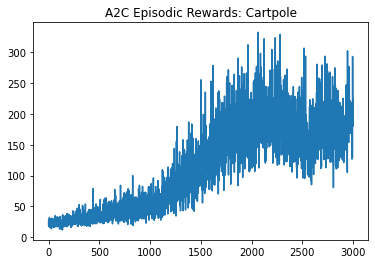

In [30]:
#not the results used in the paper just a sample run
plt.plot(range(len(np.array(avg_rewards).mean(axis=0))),np.array(avg_rewards).mean(axis=0))
plt.title('A2C Episodic Rewards: Cartpole')
plt.savefig('RL Preliminary')

In [28]:
avg_rewards

[]